# How Many Clicks Away from the Homunculus?

...

In [72]:
import sys
import json
import math
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

sys.path.append('../')
from utils import load_file, printf

# Load Min paths data between homunculus and other pages.
def min_paths(f):
    return {d["start"]: (min(d["paths"], key=len)) 
            for d in json.load(f).values()}

rand100 = load_file('datasets/random100.json', min_paths)
top50   = load_file('datasets/top50.json', min_paths)

try:
    # Load counts for the amount of links that each counts has from our cache.
    def count_pagelinks(f):
        'loop through cache and get number of links for each page.'
        cache = json.load(f)
        return Counter({k: len(v["links"]) for k, v in cache.items()})
    
    have_cache = True
    pagelinks = load_file('querycache.json', count_pagelinks)
except:
    have_cache = False
finally:
    printf("have_cache = {}", have_cache)

have_cache = True


## Estimating Average path length



In [80]:
def path_lens(p):   return Counter({k: len(v)-1 for k, v in p.items()})
def avg(c):         return sum(c.values()) / len(c)
def shortest(c, n): return c.most_common()[:-n-1:-1]
def longest(c, n):  return c.most_common(n)

rand100_lens, top50_lens = path_lens(rand100), path_lens(top50)

printf("Random100:\n\tAvg len = {},\ntop50:\n\tAvg len = {}", 
       avg(rand100_lens), avg(top50_lens))

Random100:
	Avg len = 3.94,
top50:
	Avg len = 3.48


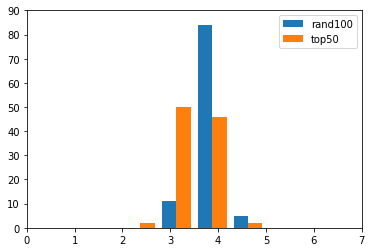

In [81]:
x = [np.array(list(rand100_lens.values())),
     np.array(list(top50_lens.values()) * 2)]
n, bins, patches = plt.hist(x, 4, label=['rand100', 'top50'])
plt.legend(prop={'size': 10})
plt.axis([0, 7, 0, 90])
plt.show()

### Errors in Bi-Directional Search.

So using the bi-directional search there will be cases where the optimal path isn't chosen. Because of this there is the possibility that the estimate will be slightly shorter. Having a look around I couldn't find a function to claculate the maximum possible error in a bi-directional search so I thought I would try and implement one based on my search implementation. Its probally not even worth doing because other factors like having such a small sample size etc will probally have a bigger effect on the results here, maybe maybe not I don't know. 

In [82]:
# some sample data that has been hand counted.
depth = range(13)
min_d = [0, 1, 2, 3, 3, 3, 4, 4, 5, 5, 6,  6,  7]
err   = [0, 0, 0, 0, 1, 2, 2, 3, 3, 4, 4,  5,  5]

def err_fn(x): return ((x + 1) >> 1) - 1 if x > 3 else 0

def test_err_fn():
    e = False
    for d in depth:
        try: 
            assert err[d] == err_fn(d)
        except:
            e = True
            printf("Error: fn({}) == {:.2f}, got={:.2f}",
                   d, err[d], err_fn(d))
    if not e:
        print("all tests pass")
test_err_fn()

all tests pass


With this function we can get the possible range of the path lengths. We will just use the `rand100` sampel this time though. 

In [83]:
sample = list(rand100_lens.values())
sum((s + (s - err_fn(s))) / 2 for s in sample) / len(sample)

3.47

### Shortest 5 paths in top 50 pages Sample

In [93]:
for k, v in shortest(top50_lens, 5):
    printf("({}) {} -> Homunculus:\n\t{}\n",
           v, k, ",\n\t".join(top50[k]))

(2) Sex -> Homunculus:
	Sex,
	Sperm,
	Homunculus

(3) United States -> Homunculus:
	United States,
	Western culture,
	History of chemistry,
	Homunculus

(3) United Kingdom -> Homunculus:
	United Kingdom,
	University College London,
	Raymond Briggs,
	Homunculus

(3) The Walking Dead (TV series) -> Homunculus:
	The Walking Dead (TV series),
	The Librarian: Curse of the Judas Chalice,
	Philosopher's stone,
	Homunculus

(3) The Big Bang Theory -> Homunculus:
	The Big Bang Theory,
	The Lord of the Rings,
	Elemental,
	Homunculus



In [87]:
print(longest(rand100_lens, 5))
print(shortest(rand100_lens, 5))

[('Bill Mundy (baseball)', 5), ('Iowa and St. Louis Railway', 5), ('Ricky Tosso', 5), ('Rosane Kirch', 5), ('Vermont 100 Mile Endurance Run', 5)]
[('The Heritage Press', 3), ('Sophronica subdivisa', 3), ('Science-Fantasy Quintette', 3), ('Saishō-ji', 3), ('RPWL', 3)]


### Comaring to Watts–Strogatz model estimation.

The Watts-Strogatz model is a super simple model for generating and calculating characteristics in graphs that exhibit small world characteristics. Being so simple to calculate the average path length it makes a easy comparison. The formula for this in a random graph is as follows:
$\ell \approx \frac{\ln N}{\ln K}$. Where `K` = average number of neighbours for each node and `N` = number of nodes. 

We can get N from https://en.wikipedia.org/wiki/Wikipedia:Size_of_Wikipedia which is currently 5509358 (11/11/2017)

In [50]:
if have_cache:
    N, K = 5509358, avg(pagelinks)
    WS = math.log(N) / math.log(K)
    printf("Where:\n\tN = {},\n\tK = {:.2f}\n\npath len = {:.2f}", N, K, WS)
else: 
    print("Need querycahe.json file")

Where:
	N = 5509358,
	K = 121.74

path len = 3.23
